# Домашнее задание 5. Линейные модели

In [37]:
%matplotlib inline

In [38]:
import sys

import random as pr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv
import sklearn.metrics as sm

Зачитываем результат 4 домашки

In [39]:
data = np.load("../hw4/files/out_4.dat.npz")
users = data["users"]
X = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [40]:
TRAINING_SET_URL = "../hw1/twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["twitter_id", "is_1", "is_2", "is_3"], dtype={"twitter_id": str, "is_1": int, 'is_2': int, "is_3": int})
df_users.set_index("twitter_id", inplace=True)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [41]:
def f(x):
    if x[0] == 1:
        return 1
    if x[1] == 1:
        return 2
    if x[2] == 1:
        return 3

Y = df_users[['is_1', 'is_2', 'is_3']].apply(f, axis=1).values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (3000x364911) feature matrix, 3000 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

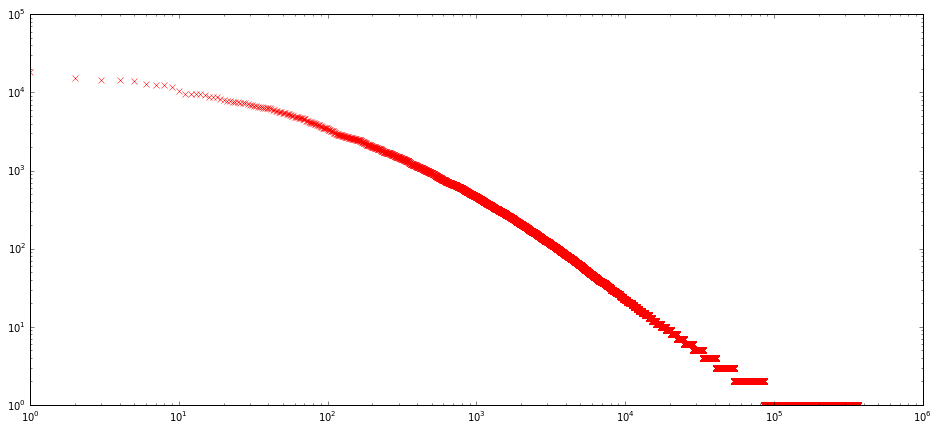

In [42]:
def draw_log_hist(X):
    """
    Draw tokens histogram in log scales
    """
    y = np.array(X.sum(axis=0), dtype=np.int).ravel()
    x = np.arange(y.size)
    
    plt.figure(figsize=(16, 7))
    plt.xscale("log", nonposx='clip')
    plt.yscale("log", nonposy='clip')
    
    plt.plot(x, np.sort(y)[::-1], "rx")
    
    return y

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [43]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [44]:
USER_NAME = "b.kopin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [45]:
def log_logistic(X, out=None):
    """Compute the log of the logistic function, ``log(1 / (1 + e ** -x))``.

    This implementation is numerically stable because it splits positive and
    negative values::

        -log(1 + exp(-x_i))     if x_i > 0
        x_i - log(1 + exp(x_i)) if x_i <= 0

    For the ordinary logistic function, use ``sklearn.utils.fixes.expit``.

    Parameters
    ----------
    X: array-like, shape (M, N) or (M, )
        Argument to the logistic function

    out: array-like, shape: (M, N) or (M, ), optional:
        Preallocated output array.

    Returns
    -------
    out: array, shape (M, N) or (M, )
        Log of the logistic function evaluated at every point in x

    Notes
    -----
    See the blog post describing this implementation:
    http://fa.bianp.net/blog/2013/numerical-optimizers-for-logistic-regression/
    """
    is_1d = X.ndim == 1
    X = np.atleast_2d(X)

    n_samples, n_features = X.shape

    if out is None:
        out = np.empty_like(X)
    
    out = np.log(1 / (1 + np.e ** -X))

    if is_1d:
        return np.squeeze(out)
    return out

In [46]:
def _logistic_loss_and_grad(w, X, y, alpha):
    """Computes the logistic loss and gradient.

    Parameters
    ----------
    w : ndarray, shape (n_features,) or (n_features + 1,)
        Coefficient vector.

    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training data.

    y : ndarray, shape (n_samples,)
        Array of labels.

    alpha : float
        Regularization parameter. alpha is equal to 1 / C.

    sample_weight : array-like, shape (n_samples,) optional
        Array of weights that are assigned to individual samples.
        If not provided, then each sample is given unit weight.

    Returns
    -------
    out : float
        Logistic loss.

    grad : ndarray, shape (n_features,) or (n_features + 1,)
        Logistic gradient.
    """
    _, n_features = X.shape
    grad = np.empty_like(w)

    yz = y * X.dot(w)

    # Logistic loss is the negative of the log of the logistic function.
    out = -np.sum(log_logistic(yz)) + .5 * alpha * np.dot(w, w)

    z = 1.0 / (1.0 + np.exp(-yz))
    z0 = (z - 1) * y

    grad[:n_features] = X.T.dot(z0) + alpha * w

    # Case where we fit the intercept.
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum()
    return out, grad

In [47]:
def _sigmoid(z):
        """
        Return Sigmoid of z
        Args:
            z : ndarray or scalar
        """
        return 1.0 / (1.0 + np.exp(-z))

In [48]:
class LogisticRegression():
    """Logistic Regression (aka logit, MaxEnt) classifier.

    In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
    scheme if the 'multi_class' option is set to 'ovr' and uses the
    cross-entropy loss, if the 'multi_class' option is set to 'multinomial'.
    (Currently the 'multinomial' option is supported only by the 'lbfgs' and
    'newton-cg' solvers.)

    This class implements regularized logistic regression using the
    `liblinear` library, newton-cg and lbfgs solvers. It can handle both
    dense and sparse input. Use C-ordered arrays or CSR matrices containing
    64-bit floats for optimal performance; any other input format will be
    converted (and copied).

    The newton-cg and lbfgs solvers support only L2 regularization with primal
    formulation. The liblinear solver supports both L1 and L2 regularization,
    with a dual formulation only for the L2 penalty.

    Read more in the :ref:`User Guide <logistic_regression>`.

    Parameters
    ----------
    penalty : str, 'l1' or 'l2'
        Used to specify the norm used in the penalization. The newton-cg and
        lbfgs solvers support only l2 penalties.

    C : float, optional (default=1.0)
        Inverse of regularization strength; must be a positive float.
        Like in support vector machines, smaller values specify stronger
        regularization.

    fit_intercept : bool, default: True
        Specifies if a constant (a.k.a. bias or intercept) should be
        added to the decision function.

    class_weight : dict or 'balanced', optional
        Weights associated with classes in the form ``{class_label: weight}``.
        If not given, all classes are supposed to have weight one.

        The "balanced" mode uses the values of y to automatically adjust
        weights inversely proportional to class frequencies in the input data
        as ``n_samples / (n_classes * np.bincount(y))``

        Note that these weights will be multiplied with sample_weight (passed
        through the fit method) if sample_weight is specified.

        .. versionadded:: 0.17
           *class_weight='balanced'* instead of deprecated *class_weight='auto'*.

    max_iter : int
        Useful only for the newton-cg, sag and lbfgs solvers.
        Maximum number of iterations taken for the solvers to converge.

    multi_class : str, {'ovr', 'multinomial'}
        Multiclass option can be either 'ovr' or 'multinomial'. If the option
        chosen is 'ovr', then a binary problem is fit for each label. Else
        the loss minimised is the multinomial loss fit across
        the entire probability distribution. Works only for the 'lbfgs'
        solver.

    Attributes
    ----------
    coef_ : array, shape (n_classes, n_features)
        Coefficient of the features in the decision function.

    intercept_ : array, shape (n_classes,)
        Intercept (a.k.a. bias) added to the decision function.
        If `fit_intercept` is set to False, the intercept is set to zero.

    n_iter_ : array, shape (n_classes,) or (1, )
        Actual number of iterations for all classes. If binary or multinomial,
        it returns only 1 element. For liblinear solver, only the maximum
        number of iteration across all classes is given.
    """
    
    def __init__(self, penalty='l1', tol=1e-4, C=1.0, B=0.5,
                 fit_intercept=True, class_weight=None,
                 max_iter=100, multi_class='ovr'):

        self.penalty = penalty
        self.tol = tol
        self.C = C
        self.B = B
        self.fit_intercept = fit_intercept
        self.class_weight = class_weight
        self.max_iter = max_iter
        self.multi_class = multi_class
        
    def _bin_fit(self, X, y=None):
        n_samples, n_features = X.shape

        current_log_likelihood = None
        self.converged_ = False
       
        coef_ = np.zeros(n_features)
        
        for i in range(self.max_iter):
            sys.stdout.write("\r Iter = %i" % (i))
            sys.stdout.flush()

            prev_log_likelihood = current_log_likelihood
            
            current_log_likelihood, grad = _logistic_loss_and_grad(coef_, X, y, 1.0 / self.C)

            eta = (i + 1) ** (-self.B)
            coef_ -= eta * grad
            
            # Check for convergence.
            if np.all(np.abs(eta * grad) < self.tol):
                self.converged_ = True
                sys.stdout.flush()
                break
        
        return coef_
    
    def fit(self, X, y=None):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
            
        n_samples, n_features = X.shape
        
        self.classes_ = np.unique(y)
        m_classes = self.classes_.shape[0]
        
        self.coef_ = np.zeros((m_classes, n_features))
        
        for i, class_label in enumerate(self.classes_):
            sys.stdout.write("\r Class = %i \n" % (class_label))
            
            y_i = np.empty_like(y)[y == class_label] = 1
            self.coef_[i, :] = self._bin_fit(X, y_i)
        
            sys.stdout.flush()

        return self
    
    def predict_proba(self, X):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

        n_samples, n_features = X.shape
        m_classes = self.classes_.shape[0]
        
        multi_y = np.zeros((m_classes, n_samples))
        
        for i, class_label in enumerate(self.classes_):
            multi_y[0, :] = (1.0 / (1.0 + np.exp(-X.dot(self.coef_[i]))))
            
        print multi_y
        


Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [49]:
lg = LogisticRegression(max_iter=1000)
lg.fit(X1, Y)


 Class = 1 
 Class = 2 
 Class = 3 
 Iter = 57

<__main__.LogisticRegression instance at 0x11eba2cb0>

In [50]:
lg.converged_

True

In [51]:
x_train, x_test, y_train, y_test = cv.train_test_split(X1, Y, test_size=0.33)


In [52]:
lg.coef_

array([[  2.83701910e+00,   1.44242074e-02,   6.46645923e-03, ...,
          3.92202744e-05,   3.13064453e-03,   2.53970323e-05],
       [  2.83701910e+00,   1.44242074e-02,   6.46645923e-03, ...,
          3.92202744e-05,   3.13064453e-03,   2.53970323e-05],
       [  2.83701910e+00,   1.44242074e-02,   6.46645923e-03, ...,
          3.92202744e-05,   3.13064453e-03,   2.53970323e-05]])

In [53]:
lg.predict_proba(x_test[:10])

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [54]:
def auroc(y_prob, y_true):
    return 0.5

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [55]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    return C.index(max(C))

index = select_reg_parameter(C, X1, Y)
print index


7


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

In [ ]:
def predict(X, Y, test_size, C):
    Y_test = [1,2,3]*300
    Y_prob = [[0.1,0.2,0.7]]*900
    return Y_test, Y_prob

def roc(Y_test, Y_prob, y_prob_ind, pos_label):
    tpr = [1] * 2400
    fpr = [0.01] * 2400
    roc_auc = 0.51
    
    return tpr, fpr, roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    # Your code here
    return

Y_test, Y_prob = predict(X1, Y, 0.3, C[index1])

tpr, fpr, roc_auc = roc(Y_test, Y_prob, 0, 1)
print "Area under the ROC curve : %f" % roc_auc
plot_roc_curve(tpr, fpr, roc_auc)

tpr, fpr, roc_auc = roc(Y_test, Y_prob, 1, 2)
print "Area under the ROC curve : %f" % roc_auc
plot_roc_curve(tpr, fpr, roc_auc)

tpr, fpr, roc_auc = roc(Y_test, Y_prob, 2, 3)
print "Area under the ROC curve : %f" % roc_auc
plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате.